In [98]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [99]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import cv2
import pathlib
import os
from PIL import Image

In [100]:
#storing path of dataset
dataset_path = pathlib.Path('/content/gdrive/MyDrive/Classification of healthy haires and alopecia areata/proposed dataset')

In [101]:
classes = os.listdir(dataset_path)

In [102]:
hh_path = os.path.join(dataset_path,classes[0])

In [103]:
#storing all the image names
hh_image_names = os.listdir(hh_path)

In [104]:
aa_path = os.path.join(dataset_path,classes[1])

In [105]:
#storing all the images names
aa_image_names = os.listdir(aa_path)

In [106]:
hh_images_path = []
for image_name in hh_image_names:
  image_path = os.path.join(hh_path, image_name)
  hh_images_path.append(image_path)

In [107]:
#number of images of healthy hairs
len(hh_images_path)

93

In [108]:
aa_images_path = []
for image_name in aa_image_names:
  image_path = os.path.join(aa_path, image_name)
  aa_images_path.append(image_path)

In [109]:
#number of images of alopecia aereta
len(aa_images_path)

200

In [110]:
all_images_path = []
all_images_path.extend(hh_images_path)
all_images_path.extend(aa_images_path)

In [111]:
#total number of images 
len(all_images_path)

293

**Preprocessing**

In [112]:
#applying he on all images
from tqdm import tqdm
clahe_images = []
for i in tqdm(range(len(all_images_path))):
  image = cv2.imread(all_images_path[i])
  img_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
  clahe = cv2.createCLAHE(clipLimit =2.0, tileGridSize=(8,8))
  img_yuv[:,:,0] = clahe.apply(img_yuv[:,:,0])
  img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
  clahe_images.append(img_output)

100%|██████████| 293/293 [00:05<00:00, 52.91it/s]


Text(0.5, 1.0, 'With clahe')

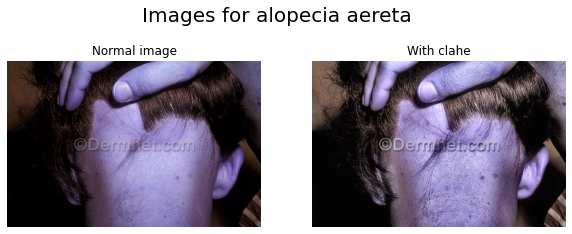

In [113]:
#plotting the he and normal images of alopecia aereta
image = cv2.imread(all_images_path[3])
fig = plt.figure(figsize=(10, 7))
fig.suptitle('Images for alopecia aereta', fontsize=20)
fig.add_subplot(2, 2, 1)
plt.imshow(image)
plt.axis('off')
plt.title('Normal image')
fig.add_subplot(2, 2, 2)
plt.imshow(clahe_images[3])
plt.axis('off')
plt.title('With clahe')


Text(0.5, 1.0, 'With clahe')

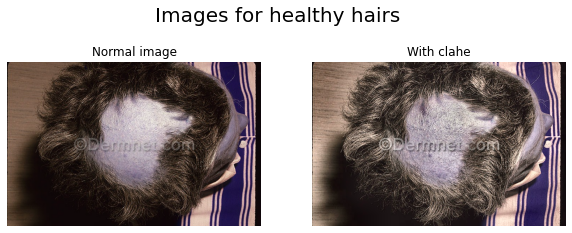

In [114]:
#plotting the he and normal images of alopecia aereta
image = cv2.imread(all_images_path[56])
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(2, 2, 1)
fig.suptitle('Images for healthy hairs', fontsize=20)
plt.imshow(image)
plt.axis('off')
plt.title('Normal image')
fig.add_subplot(2, 2, 2)
plt.imshow(clahe_images[56])
plt.axis('off')
plt.title('With clahe')


In [115]:
# Define  labels[], and data[]
labels = []  
classes = []
data = []
from tqdm import tqdm

for i in tqdm(range(len(clahe_images))):
    image = clahe_images[i].astype('float32')
    image=cv2.resize(image, (224,224)) #resizing
    image /= 255  #scaling image
    data.append(image)
    cls = all_images_path[i].split(os.path.sep)[-2] #splitting  path
    if cls == 'alopecia areata':
        lbl = 0
        classes.append('alopecia areata') 
    else:
        lbl=1
        classes.append('Healthy Hairs')
    labels.append(lbl) #storing the labels for images i.e alopecia aereta - 0 and healthy hairs - 1 

100%|██████████| 293/293 [00:00<00:00, 516.25it/s]


In [116]:
data = np.array(data)
labels=np.array(labels)
print(labels.shape)
print(data.shape)

(293,)
(293, 224, 224, 3)


In [117]:
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator

In [118]:
from sklearn.model_selection import train_test_split
#splitting the data
x_train,x_test,y_train,y_test=train_test_split(data,labels,test_size=0.2,random_state=22)

In [119]:
y_train.shape

(234,)

In [120]:
#applying data augumentation using ImageGenerator library provided in keras.preprocessing on training data
data_generator = tf.keras.preprocessing.image.ImageDataGenerator( rotation_range=35, width_shift_range=0.2,
    height_shift_range=0.2, shear_range=0.2, zoom_range=0.2)

In [121]:
data_generator.fit(x_train)

In [122]:
VGG_model = tf.keras.applications.VGG16(input_shape=(224,224,3),include_top=False,weights="imagenet")

In [123]:
for layer in VGG_model.layers:
  layer.trainable = False
VGG_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

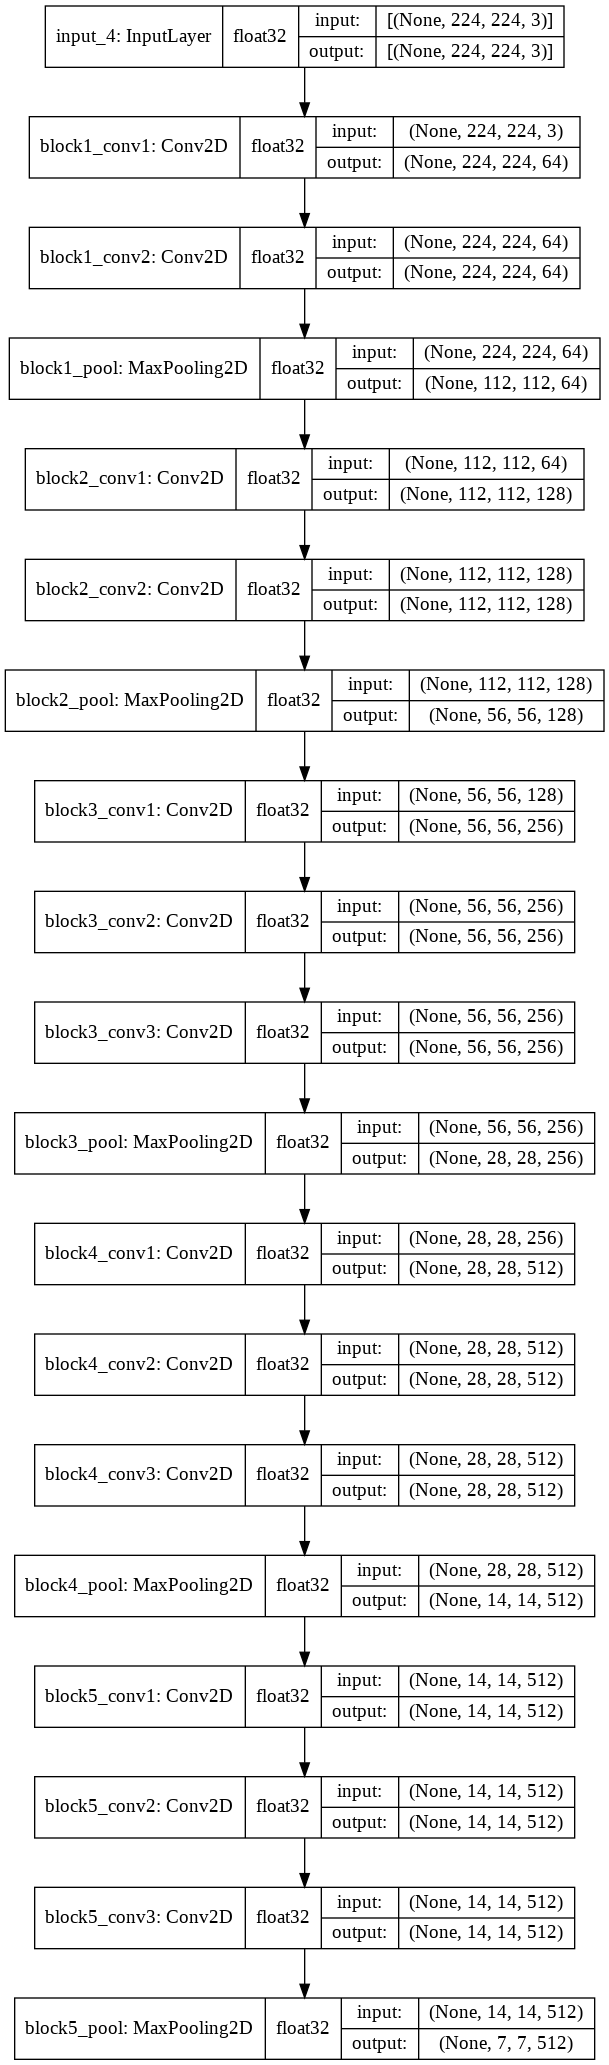

In [124]:
tf.keras.utils.plot_model(
    VGG_model,
    to_file="./model_propose_hair_classification.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    dpi=96,
)

In [125]:
feature_extractor = VGG_model.predict(x_train)

In [126]:
feature_extractor.shape

(234, 7, 7, 512)

In [127]:
features = feature_extractor.reshape(feature_extractor.shape[0],-1)

In [128]:
features.shape

(234, 25088)

In [129]:
#building SVM classifier
from sklearn.svm import SVC
svclassifier = SVC(kernel='rbf')
#fitting the model
svclassifier.fit(features, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [130]:
feature_extractor_test = VGG_model.predict(x_test)

In [131]:
x_test_features = feature_extractor_test.reshape(feature_extractor_test.shape[0],-1)

In [132]:
x_test_features.shape

(59, 25088)

In [133]:
#predicting the outputs
y_pred=svclassifier.predict(x_test_features)

In [134]:
len(x_test)

59

In [135]:
len(y_test)

59

In [136]:
len(y_pred)

59

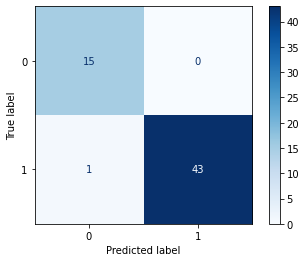

In [137]:
#confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay , classification_report
labels=['0', '1']
cm1 = confusion_matrix(y_pred,y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [138]:
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_test, y_pred)*100)
sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity : ', specificity1)

Accuracy: 98.30508474576271
Sensitivity :  1.0
Specificity :  0.9772727272727273


In [139]:
#classification report
target_names = ['0','1']
print(classification_report(y_test,y_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        16
           1       0.98      1.00      0.99        43

    accuracy                           0.98        59
   macro avg       0.99      0.97      0.98        59
weighted avg       0.98      0.98      0.98        59

